In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../Downloads/st_export.csv").iloc[:,1:]
for i in range(len(df)):
    df.iloc[i,-3]=df.iloc[i,-3].split("GMT")[0].strip()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.tail()

,klineacc,spread,spreadper,x,vwap,deviation,ratio,term,sigma,e,h,asset,timestamp,gap,gaplimit
105582,243009088,-1.515287e+06,-19.108099,-0.876498,93193.875000,-0.000261,1.191081,0.377895,0.003526,-0.033286,-0.033273,BTC,2025-12-03 18:38:29,1m,300
105583,23125126,4.245218e+05,7.591727,0.843956,900.395813,-0.002661,0.924083,0.098463,0.003769,-0.064230,-0.064142,BNB,2025-12-03 18:38:29,1m,300
105584,42380120,7.252953e+06,31.355587,0.671879,142.525360,-0.005300,0.686444,0.283867,0.003895,-0.265120,-0.259078,SOL,2025-12-03 18:38:29,1m,300
105585,26964774,1.052250e+05,1.282841,0.886435,2.196158,-0.005946,0.987172,0.234254,0.004464,-0.308050,-0.298662,XRP,2025-12-03 18:38:29,1m,300
105586,27078804,-5.835642e+05,-22.478600,-0.839400,1.742947,-0.013854,1.224786,0.565329,0.010542,-0.909957,-0.721112,SUI,2025-12-03 18:38:29,1m,300


In [4]:
df = df.sort_values('timestamp')

# -----------------------------
# 2. Create lag features
# -----------------------------
df['vwap_lag1'] = df['vwap'].shift(1)
df['spread_lag1'] = df['spread'].shift(1)
df['ratio_lag1'] = df['ratio'].shift(1)
df['sigma_lag1'] = df['sigma'].shift(1)

# new

In [9]:
df['return'] = df['vwap'].pct_change()

# Lag features for VWAP and other columns
for col in ['vwap','spread','ratio','sigma','e','h']:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)
    df[f'{col}_lag3'] = df[col].shift(3)

# Target: next-step return
df['target'] = df['return'].shift(-1)

# Drop rows with NaN (from lagging)
df = df.dropna()

# -----------------------------
# 3. Define features and target
# -----------------------------
feature_cols = [c for c in df.columns if 'lag' in c]
X = df[feature_cols]
y = df['target']

# -----------------------------
# 4. Train/test split (time-series style)
# -----------------------------
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# -----------------------------
# 5. Train model
# -----------------------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# -----------------------------
# 6. Evaluate
# -----------------------------
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2:", r2)
print("RMSE:", rmse)

# Feature importance
importances = model.feature_importances_
for feat, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.4f}")

R^2: -0.08376070126411683
RMSE: 7945.375585005483
vwap_lag2: 0.0792
vwap_lag1: 0.0787
vwap_lag3: 0.0762
sigma_lag1: 0.0694
sigma_lag2: 0.0691
sigma_lag3: 0.0687
spread_lag3: 0.0684
spread_lag2: 0.0605
spread_lag1: 0.0602
ratio_lag3: 0.0594
ratio_lag1: 0.0566
ratio_lag2: 0.0565
e_lag3: 0.0352
e_lag1: 0.0343
h_lag1: 0.0335
e_lag2: 0.0327
h_lag3: 0.0314
h_lag2: 0.0300


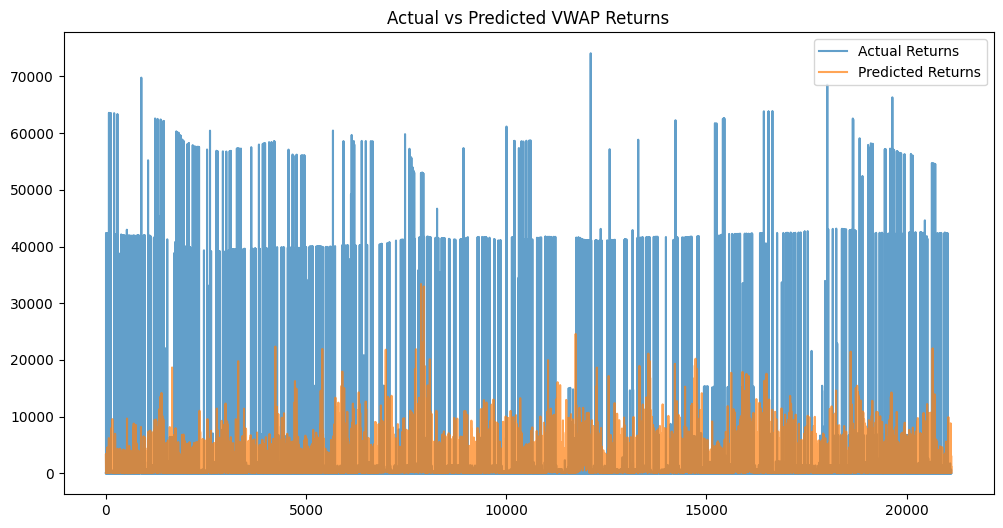

In [12]:
# -----------------------------
# 7. Plot actual vs predicted
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Returns", alpha=0.7)
plt.plot(y_pred, label="Predicted Returns", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted VWAP Returns")
plt.show()

# another new

In [24]:
# -----------------------------
# 2. Focus on one asset (e.g. BTC)
# -----------------------------
btc_df = df[df['asset'] == 'BTC'].copy()

# Compute returns
btc_df['return'] = btc_df['vwap'].pct_change()

# -----------------------------
# 3. Create lag features for ALL columns
# -----------------------------
feature_cols = ['klineacc','spread','spreadper','x','vwap','deviation',
                'ratio','term','sigma','e','h']

for col in feature_cols:
    btc_df[f'{col}_lag1'] = btc_df[col].shift(1)
    btc_df[f'{col}_lag2'] = btc_df[col].shift(2)
    btc_df[f'{col}_lag3'] = btc_df[col].shift(3)

# Target = next-step return
btc_df['target'] = btc_df['return'].shift(-1)

# Drop NaN rows
btc_df = btc_df.dropna()

# -----------------------------
# 4. Define features and target
# -----------------------------
X = btc_df[[c for c in btc_df.columns if 'lag' in c]]
y = btc_df['target']

# -----------------------------
# 5. Train/test split (time-series style)
# -----------------------------
split_idx = int(len(btc_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# -----------------------------
# 6. Train model
# -----------------------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


R^2: -0.04823550708641311
RMSE: 0.00703644137988328
x_lag2: 0.0527
x_lag3: 0.0514
deviation_lag3: 0.0511
vwap_lag1: 0.0496
deviation_lag1: 0.0460
vwap_lag2: 0.0425
klineacc_lag1: 0.0418
x_lag1: 0.0411
deviation_lag2: 0.0400
vwap_lag3: 0.0386
klineacc_lag2: 0.0369
klineacc_lag3: 0.0365
spread_lag2: 0.0341
spread_lag3: 0.0312
spread_lag1: 0.0279
term_lag1: 0.0265
sigma_lag1: 0.0263
term_lag3: 0.0253
term_lag2: 0.0227
sigma_lag2: 0.0226
e_lag2: 0.0207
sigma_lag3: 0.0206
e_lag3: 0.0206
ratio_lag2: 0.0202
spreadper_lag2: 0.0202
h_lag1: 0.0201
spreadper_lag3: 0.0196
h_lag3: 0.0195
e_lag1: 0.0195
spreadper_lag1: 0.0190
h_lag2: 0.0190
ratio_lag1: 0.0184
ratio_lag3: 0.0177


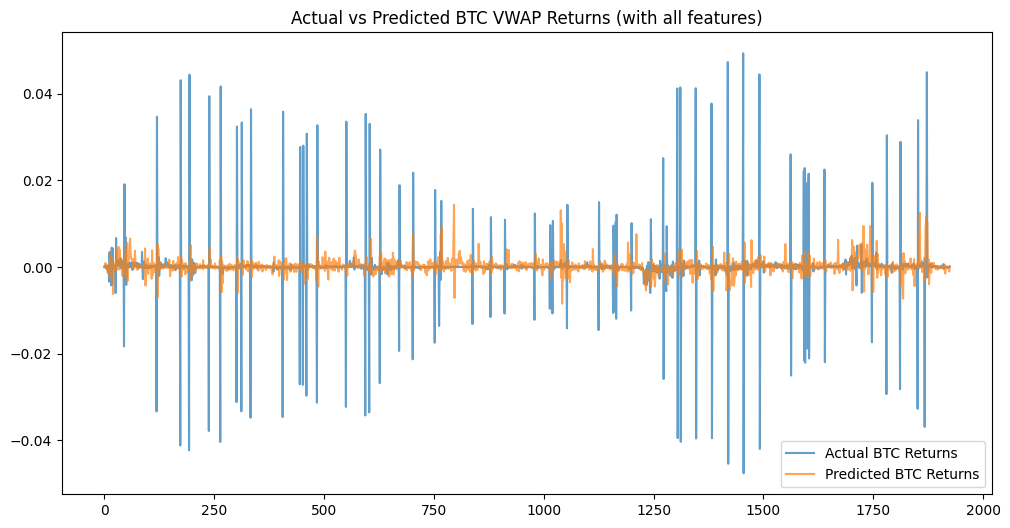

In [25]:
# -----------------------------
# 7. Evaluate
# -----------------------------
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2:", r2)
print("RMSE:", rmse)

# Feature importance
importances = model.feature_importances_
for feat, imp in sorted(zip(X.columns, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.4f}")

# -----------------------------
# 8. Plot actual vs predicted
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual BTC Returns", alpha=0.7)
plt.plot(y_pred, label="Predicted BTC Returns", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted BTC VWAP Returns (with all features)")
plt.show()


# another one new

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Try to use XGBoost; if not available, fallback to RandomForest
use_xgb = True
try:
    from xgboost import XGBClassifier
except Exception:
    use_xgb = False
from sklearn.ensemble import RandomForestClassifier

In [35]:
# Ensure expected columns exist
expected_cols = [
    'klineacc', 'spread', 'spreadper', 'x', 'vwap', 'deviation', 'ratio',
    'term', 'sigma', 'e', 'h', 'asset', 'timestamp', 'gap', 'gaplimit'
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in input: {missing}")

# Convert timestamp and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')



In [36]:
# -----------------------------
# 2) Select assets to include
# -----------------------------
selected_assets = ['BTC', 'ETH', 'SOL', 'BNB', 'AAVE', 'PAXG']
dff = df[df['asset'].isin(selected_assets)].copy()

# -----------------------------
# 3) Pivot each feature into wide matrix by asset
# -----------------------------
feature_cols = [
    'klineacc','spread','spreadper','x','vwap','deviation',
    'ratio','term','sigma','e','h'
]

wide_frames = []
for col in feature_cols:
    w = dff.pivot_table(index='timestamp', columns='asset', values=col, aggfunc='mean')
    # rename columns to include feature name
    w.columns = [f"{col}__{a}" for a in w.columns]
    wide_frames.append(w)

# Merge all features on timestamp
wide_df = pd.concat(wide_frames, axis=1).sort_index()

# -----------------------------
# 4) Build BTC returns and binary target (next-step up/down)
# -----------------------------
# BTC VWAP column after pivot
btc_vwap_col = "vwap__BTC"
if btc_vwap_col not in wide_df.columns:
    raise ValueError("BTC VWAP column not found after pivot. Check BTC data availability.")

wide_df['btc_return'] = wide_df[btc_vwap_col].pct_change()
# Target: next-step direction (1 if next return > 0 else 0)
wide_df['target'] = (wide_df['btc_return'].shift(-1) > 0).astype(int)

# -----------------------------
# 5) Create lag features (1–3 lags) for all pivoted columns
# -----------------------------
lagged = []
for col in wide_df.columns:
    # skip target itself; we will lag btc_return but not target
    if col == 'target':
        continue
    for L in (1, 2, 3):
        lagged.append(wide_df[col].shift(L).rename(f"{col}_lag{L}"))

lag_df = pd.concat(lagged, axis=1)

# -----------------------------
# 6) Combine features and target, drop NaNs
# -----------------------------
model_df = pd.concat([lag_df, wide_df[['target']]], axis=1)
model_df = model_df.dropna()

# -----------------------------
# 7) Train/test split (time-series style)
# -----------------------------
split_ratio = 0.8
split_idx = int(len(model_df) * split_ratio)

X = model_df.drop(columns=['target'])
y = model_df['target']

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Optional scaling (helps tree-based sometimes, harmless otherwise)
scaler = StandardScaler(with_mean=False)  # sparse-safe; features may be wide
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 8) Train classifier (XGBoost CPU or RandomForest fallback)
# -----------------------------
if use_xgb:
    model = XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='binary:logistic',
        tree_method='hist',  # CPU-friendly
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
else:
    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

# -----------------------------
# 9) Evaluate
# -----------------------------
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)




/var/folders/5z/34btjl757md3wk7szryjd3ym0000gn/T/ipykernel_29344/1626409665.py:33: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  wide_df['btc_return'] = wide_df[btc_vwap_col].pct_change()


Accuracy: 0.3889
Precision: 0.5000
Recall: 0.2727
ROC AUC: 0.4675

Classification report:
              precision    recall  f1-score   support

           0     0.3333    0.5714    0.4211         7
           1     0.5000    0.2727    0.3529        11

    accuracy                         0.3889        18
   macro avg     0.4167    0.4221    0.3870        18
weighted avg     0.4352    0.3889    0.3794        18


Confusion matrix:
[[4 3]
 [8 3]]


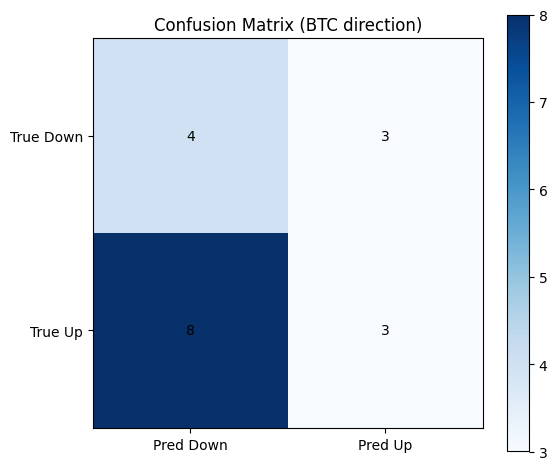

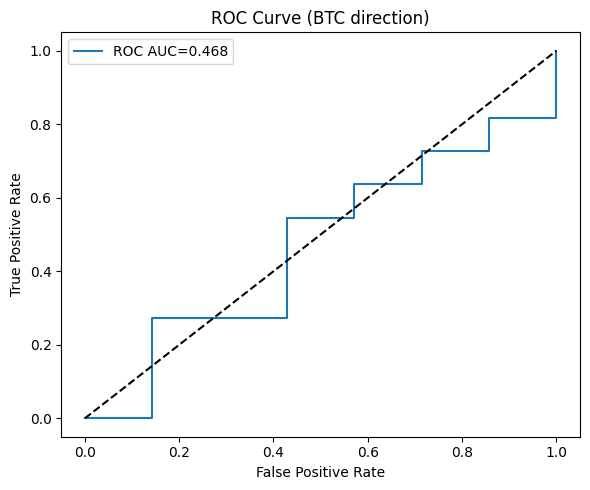


Top 25 features by importance:
x__AAVE_lag2            0.037983
e__AAVE_lag2            0.037470
h__SOL_lag2             0.035371
e__SOL_lag2             0.034600
vwap__PAXG_lag2         0.032411
spread__SOL_lag1        0.030620
ratio__SOL_lag3         0.026016
spreadper__SOL_lag2     0.024909
e__AAVE_lag3            0.024013
spreadper__AAVE_lag2    0.023564
ratio__BTC_lag3         0.023076
deviation__AAVE_lag3    0.021294
deviation__AAVE_lag1    0.019527
spread__SOL_lag3        0.018721
spreadper__AAVE_lag1    0.018187
x__PAXG_lag2            0.015117
vwap__AAVE_lag2         0.014627
vwap__SOL_lag2          0.014495
x__BNB_lag2             0.013965
spreadper__PAXG_lag3    0.013910
e__BTC_lag3             0.013845
klineacc__BNB_lag1      0.013330
h__ETH_lag3             0.012707
klineacc__BNB_lag2      0.012411
sigma__BNB_lag1         0.012119
dtype: float32


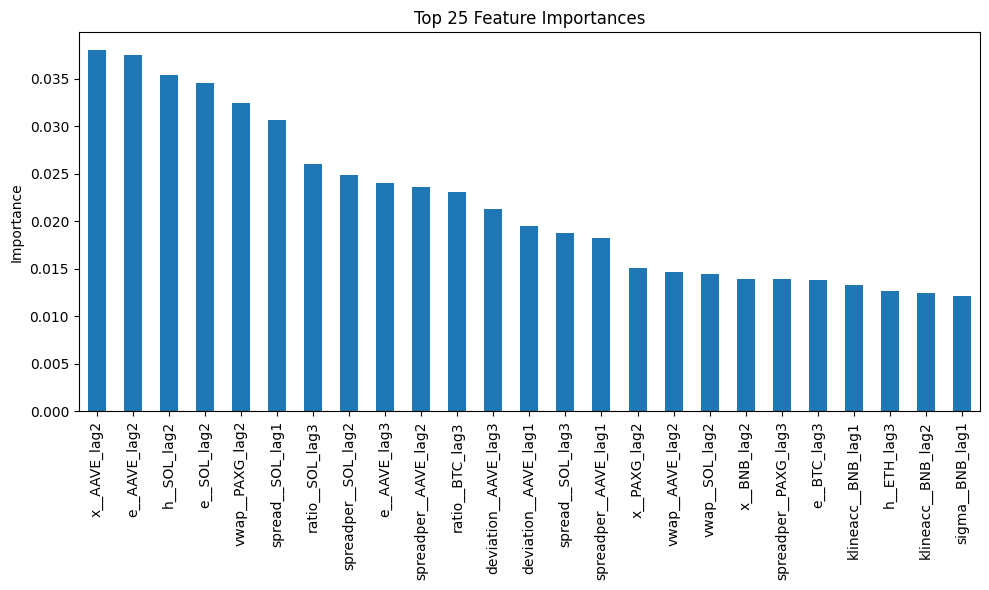

In [37]:
try:
    roc = roc_auc_score(y_test, y_proba)
except Exception:
    roc = np.nan

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"ROC AUC: {roc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:")
print(cm)

# -----------------------------
# 10) Plot confusion matrix and ROC curve
# -----------------------------
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0,1], ['Pred Down','Pred Up'])
plt.yticks([0,1], ['True Down','True Up'])
plt.title("Confusion Matrix (BTC direction)")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BTC direction)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 11) Feature importance
# -----------------------------
def get_feature_importances(model, feature_names):
    # XGBoost
    if use_xgb:
        try:
            importances = model.feature_importances_
            return pd.Series(importances, index=feature_names).sort_values(ascending=False)
        except Exception:
            pass
    # RandomForest fallback or any model with feature_importances_
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        return pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return pd.Series(dtype=float)

feat_imp = get_feature_importances(model, X.columns)
print("\nTop 25 features by importance:")
print(feat_imp.head(25))

plt.figure(figsize=(10,6))
feat_imp.head(25).plot(kind='bar')
plt.title("Top 25 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# another new new df

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# Try to use XGBoost; fallback to RandomForest if not available
use_xgb = True
try:
    from xgboost import XGBClassifier
except Exception:
    use_xgb = False
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1) Load and prepare data
# -----------------------------


In [40]:
df.head()

,klineacc,spread,spreadper,x,vwap,deviation,ratio,term,sigma,e,...,ratio_lag3,sigma_lag2,sigma_lag3,e_lag1,e_lag2,e_lag3,h_lag1,h_lag2,h_lag3,target
4,241984432,-1.825153e+06,-11.009636,-0.871893,116055.968750,-0.001977,1.110096,2.030232,0.002265,-1.967226,...,1.244208,0.004821,0.002254,-0.787122,-3.274510,-2.055113,-0.656775,-0.997141,-0.967721,-0.961221
5,426575872,-9.057356e+05,-5.183218,-0.897531,4500.592285,-0.007244,1.051832,2.763003,0.004962,-4.242387,...,0.844829,0.004429,0.004821,-1.967226,-0.787122,-3.274510,-0.961637,-0.656775,-0.997141,-0.780969
6,54527584,-1.243129e+06,-25.343220,-0.837234,985.767151,-0.003152,1.253432,0.584285,0.004198,-0.549878,...,1.354005,0.002265,0.004429,-4.242387,-1.967226,-0.787122,-0.999587,-0.961637,-0.656775,116.731911
7,241856816,-4.093186e+06,-26.111559,-0.848139,116056.250000,-0.001733,1.261116,2.007367,0.002245,-1.953924,...,1.110096,0.004962,0.002265,-0.549878,-4.242387,-1.967226,-0.500429,-0.999587,-0.961637,-0.961221
8,427520192,-6.016534e+05,-3.383045,-0.903824,4500.540527,-0.006890,1.033830,2.746325,0.004755,-4.114440,...,1.051832,0.004198,0.004962,-1.953924,-0.549878,-4.242387,-0.960624,-0.500429,-0.999587,24.783865


In [41]:
df.iloc[4,:]

klineacc                 427520192
spread                -601653.4375
spreadper                -3.383045
x                        -0.903824
vwap                   4500.540527
deviation                 -0.00689
ratio                      1.03383
term                      2.746325
sigma                     0.004755
e                         -4.11444
h                        -0.999466
asset                          ETH
timestamp      2025-09-19 23:49:31
gap                             5m
gaplimit                        60
vwap_lag1                116056.25
spread_lag1             -4093185.5
ratio_lag1                1.261116
sigma_lag1                0.002245
return                   -0.961221
vwap_lag2               985.767151
vwap_lag3              4500.592285
spread_lag2            -1243128.75
spread_lag3           -905735.5625
ratio_lag2                1.253432
ratio_lag3                1.051832
sigma_lag2                0.004198
sigma_lag3                0.004962
e_lag1              

In [42]:
# df = pd.read_csv("your_file.csv")
# df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

selected_assets = ['BTC','ETH','SOL','BNB','AAVE','PAXG']
dff = df[df['asset'].isin(selected_assets)].copy()

feature_cols = [
    'klineacc','spread','spreadper','x','vwap','deviation',
    'ratio','term','sigma','e','h'
]

# -----------------------------
# 2) Pivot features by asset
# -----------------------------
wide_frames = []
for col in feature_cols:
    w = dff.pivot_table(index='timestamp', columns='asset', values=col, aggfunc='mean')
    w.columns = [f"{col}__{a}" for a in w.columns]
    wide_frames.append(w)

wide_df = pd.concat(wide_frames, axis=1).sort_index()

# -----------------------------
# 3) Compute BTC returns and 3-class target
# -----------------------------
btc_vwap_col = "vwap__BTC"
wide_df['btc_return'] = wide_df[btc_vwap_col].pct_change()



/var/folders/5z/34btjl757md3wk7szryjd3ym0000gn/T/ipykernel_29344/867431408.py:28: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  wide_df['btc_return'] = wide_df[btc_vwap_col].pct_change()


In [47]:
# Thresholds for classification
neutral_thresh = 0.001  # 0.1% move considered neutral
def classify_return(r):
    if r > neutral_thresh:
        return 2  # Up
    elif r < -neutral_thresh:
        return 0  # Down
    else:
        return 1  # Neutral

wide_df['target'] = wide_df['btc_return'].shift(-1).apply(classify_return)

# -----------------------------
# 4) Create lag features (1–3 lags)
# -----------------------------
lagged = []
for col in wide_df.columns:
    if col == 'target':
        continue
    for L in (1,2,3):
        lagged.append(wide_df[col].shift(L).rename(f"{col}_lag{L}"))

lag_df = pd.concat(lagged, axis=1)

# -----------------------------
# 5) Combine features and target
# -----------------------------
model_df = pd.concat([lag_df, wide_df[['target']]], axis=1).dropna()

X = model_df.drop(columns=['target'])
y = model_df['target']

# -----------------------------
# 6) Train/test split (time-series style)
# -----------------------------
split_idx = int(len(model_df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 7) Train classifier
# -----------------------------
if use_xgb:
    model = XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='multi:softmax',
        num_class=3,
        tree_method='hist',
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
else:
    model = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)




Accuracy: 0.7777777777777778

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.7778    1.0000    0.8750        14
           2     0.0000    0.0000    0.0000         2

    accuracy                         0.7778        18
   macro avg     0.2593    0.3333    0.2917        18
weighted avg     0.6049    0.7778    0.6806        18


Confusion matrix:
 [[ 0  2  0]
 [ 0 14  0]
 [ 0  2  0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

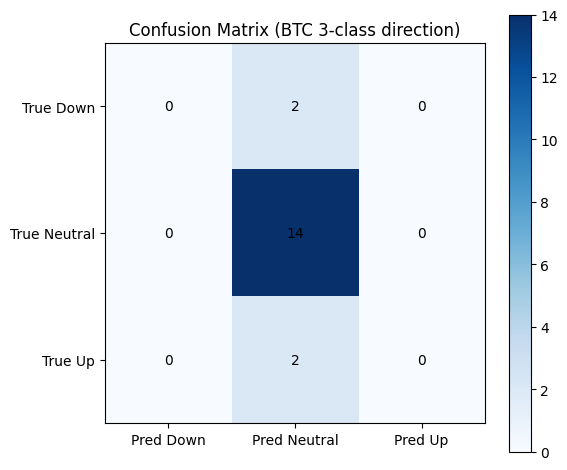


Top 25 features by importance:
h__PAXG_lag3            0.028010
spreadper__AAVE_lag2    0.025711
e__AAVE_lag2            0.022430
deviation__PAXG_lag2    0.020313
e__PAXG_lag1            0.018242
deviation__PAXG_lag1    0.018223
deviation__BNB_lag1     0.017916
sigma__BTC_lag1         0.017835
vwap__AAVE_lag1         0.016483
spread__SOL_lag1        0.015803
x__AAVE_lag3            0.015633
spread__AAVE_lag2       0.015287
vwap__BTC_lag2          0.014207
sigma__AAVE_lag2        0.013928
klineacc__SOL_lag1      0.012972
sigma__BTC_lag3         0.012313
ratio__SOL_lag2         0.012189
sigma__SOL_lag3         0.011911
e__ETH_lag1             0.011590
klineacc__AAVE_lag2     0.011412
x__SOL_lag1             0.011373
btc_return_lag2         0.010892
spread__BTC_lag3        0.010632
term__ETH_lag3          0.010370
x__BTC_lag3             0.010302
dtype: float32


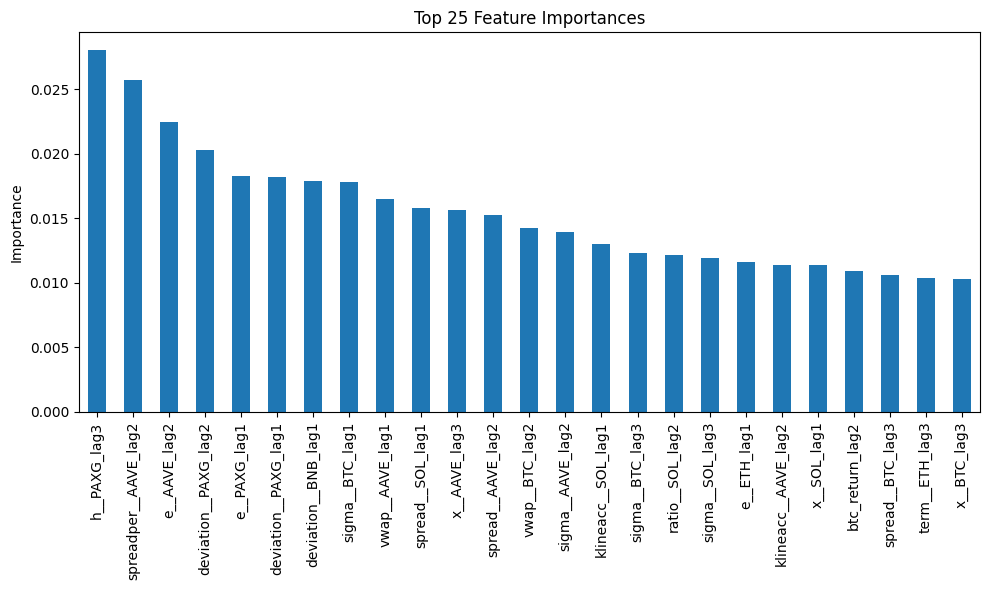

In [48]:
# -----------------------------
# 8) Evaluate
# -----------------------------
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2], ['Pred Down','Pred Neutral','Pred Up'])
plt.yticks([0,1,2], ['True Down','True Neutral','True Up'])
plt.title("Confusion Matrix (BTC 3-class direction)")
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

# -----------------------------
# 9) Feature importance
# -----------------------------
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    print("\nTop 25 features by importance:")
    print(feat_imp.head(25))
    plt.figure(figsize=(10,6))
    feat_imp.head(25).plot(kind='bar')
    plt.title("Top 25 Feature Importances")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()